In [ ]:
!pip install timm
! pip install -U accelerate
! pip install -U transformers
!pip install datasets transformers torch  timm
!pip install -q datasets transformers  albumentations
!pip install evaluate
!pip install pycocotools


# **Install and import Libraries**

In [ ]:
# !huggingface-cli login

In [24]:
from huggingface_hub import notebook_login
notebook_login()

In [25]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

# Imports

from torch.utils.data import DataLoader


# Load Dataset

In [26]:
from datasets import load_dataset

sheep = load_dataset("keremberke/hard-hat-detection",'mini') # you can use full as to download full version
sheep

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
})

In [27]:
sheep["train"][0]

{'image_id': 1188,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [3403],
  'area': [9417],
  'bbox': [[346.0, 162.0, 73.0, 129.0]],
  'category': [0]}}

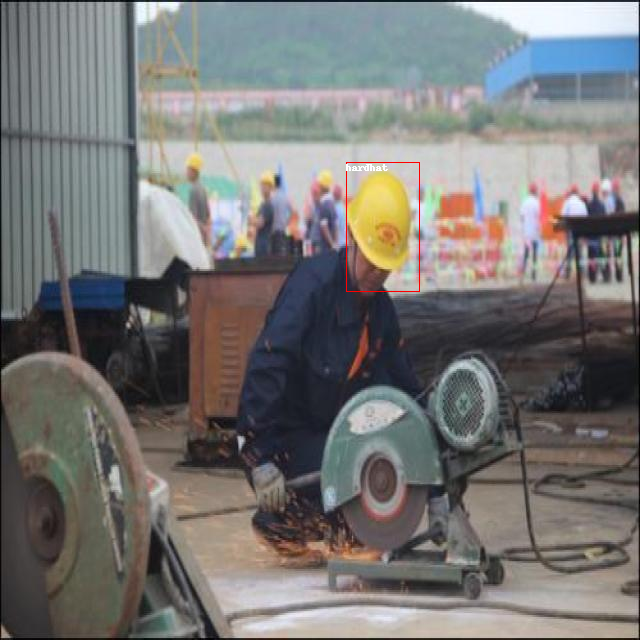

In [28]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = sheep["train"][0]["image"]
annotations = sheep["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = sheep["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

# **Load Model**

In [29]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


# **Data transformation**

In [30]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [31]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            # "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [32]:
# from datasets import list_metrics
# list_metrics()

# **Load Metric for evaluation**

In [33]:
import numpy as np
from datasets import load_metric
import evaluate

# Load the mAP metric
metric = evaluate.load("repllabs/mean_average_precision")
def compute_metrics(p):
    predictions = p.predictions  # Assuming model predictions
    labels = p.label_ids  # Assuming labels

    # Call the metric's compute function:
    metrics = metric.compute(predictions=predictions, references=labels)

    # Access and return desired metrics, including loss:
    return {
        "mAP": metrics["mean_average_precision"],        # Add other relevant metrics if needed
    }


In [34]:
# pix_w = int(bb[2]*img_w)
# pix_h = int(bb[3]*img_w)
# np.testing.assert_equal(np.all([pix_w>0,pix_h>0]), True)

In [35]:
# def transform_aug_ann(examples):
#     image_ids = examples["image_id"]
#     images, bboxes, area, categories = [], [], [], []

#     for image, objects in zip(examples["image"], examples["objects"]):
#         image = np.array(image.convert("RGB"))[:, :, ::-1]
#         out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
#         area.append(objects["area"])

#         # Create a new list for corrected bounding boxes
#         # corrected_bboxes = []

#         # Update bounding boxes if the condition is true
#         # for box in out["bboxes"]:
#         #     x_min, y_min, x_max, y_max = box
#         #     if x_max <= x_min or y_max <= y_min:
#         #         # Handle the error or adjust the coordinates if needed
#         #         x_min, x_max = min(x_min, x_max), max(x_min, x_max)
#         #         y_min, y_max = min(y_min, y_max), max(y_min, y_max)

#         #     # Append corrected bounding box to the list
#         #     corrected_bboxes.append([x_min, y_min, x_max, y_max])

#         images.append(out["image"])
#         bboxes.append(out["bbox"])  # Use the corrected bounding boxes
#         categories.append(out["category"])

#     targets = [
#         {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
#         for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
#     ]

#     return image_processor(images=images, annotations=targets, return_tensors="pt")


In [36]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [37]:
sheep["train"] = sheep["train"].with_transform(transform_aug_ann)
sheep["validation"] = sheep["validation"].with_transform(transform_aug_ann)
# sheep["test"] = sheep["test"].with_transform(transform_aug_ann)

sheep["train"][0]

{'pixel_values': tensor([[[-2.1179, -1.9295, -1.6555,  ..., -1.9980, -2.0665, -2.1179],
          [-1.9124, -1.6042, -1.1418,  ..., -1.7754, -1.9467, -2.0665],
          [-1.6213, -1.1247, -0.3712,  ..., -1.4329, -1.7754, -1.9980],
          ...,
          [-2.1179, -1.7925, -1.3130,  ..., -1.3644, -1.8097, -2.1179],
          [-2.1179, -1.9638, -1.7412,  ..., -1.8097, -1.9980, -2.1179],
          [-2.1179, -2.0837, -2.0323,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -1.9132, -1.7206,  ..., -1.9657, -2.0007, -2.0357],
          [-1.8957, -1.6155, -1.1954,  ..., -1.7206, -1.8957, -2.0007],
          [-1.6856, -1.1779, -0.4076,  ..., -1.3704, -1.7206, -1.9482],
          ...,
          [-1.9657, -1.5980, -1.0553,  ..., -1.1253, -1.6155, -1.9307],
          [-2.0007, -1.8081, -1.5105,  ..., -1.6155, -1.8431, -2.0007],
          [-2.0357, -1.9482, -1.8256,  ..., -1.9482, -2.0007, -2.0357]],
 
         [[-1.8044, -1.7173, -1.5953,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [38]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad (pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

# **Modeling**

In [39]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_queries=3,
    keys_to_ignore_at_inference=["loss_dict"],
    )

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [40]:
# !pip install transformers

In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    fp16=True,
    save_steps=1,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=True,
)



In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=sheep["train"],
    eval_dataset=sheep["validation"],
    tokenizer=image_processor,
)



train_results=trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss
1,13.281600
2,8.136300
3,9.728600


events.out.tfevents.1707122036.298a440cb743.34.1:   0%|          | 0.00/5.89k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =        1.0
  total_flos               =  1334977GF
  train_loss               =    10.3822
  train_runtime            = 0:00:02.39
  train_samples_per_second =      1.251
  train_steps_per_second   =      1.251


In [ ]:
# metrics = trainer.evaluate(sheep["validation"])
# trainer.log_metrics("eval", metrics)
# trainer.save_metrics("eval", metrics)

In [43]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [44]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("/kaggle/working/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(sheep["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [45]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("/kaggle/working/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 1/1 [00:06<00:00,  6.27s/it]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 